This envelope is at an (approximately) constant SNR gap from the capacity. The throughput $R (1 - Pe)$ is thus a shifted version of the capacity

$$ R (1 - P_e) = B log_2(1 + \frac{SINR}{\Gamma}) $$ 
where 
$$ SINR = \frac{S}{I + N} $$

Since Probability Error Rate is negligible, SNR is negligible because Intercell Interference is magnitudes higher, and SNR Gap $\Gamma = 4$,
$$ R = B log_2(1 + \frac{SIR}{4}) $$ 

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
##ction to plot a hexagon
def plot_hexagon(ax, center_x, center_y, radius, color='black'):
    angles = np.linspace(0, 2 * np.pi, 7)
    x_hex = center_x + radius * np.cos(angles)
    y_hex = center_y + radius * np.sin(angles)
    ax.plot(x_hex, y_hex, color=color)
    ax.fill(x_hex, y_hex, color=color, alpha=0.1)

# Function to plot a cell with 3 sectors
def plot_cell_with_sectors(ax, center_x, center_y, radius):
    # Draw the cell's hexagonal boundary
    plot_hexagon(ax, center_x, center_y, radius)

    # Draw the 3 sectors within each cell (120° each)
    for i in range(3):
        angle = i * (2 * np.pi / 3)  # Starting angle for each sector
        x_sector = [center_x, center_x + radius * np.cos(angle)]
        y_sector = [center_y, center_y + radius * np.sin(angle)]
        ax.plot(x_sector, y_sector, color='gray', linestyle='--')
        
# Function to generate random points inside hexagonal areas
def is_point_in_hexagon(x, y, center_x, center_y, radius):
    angles = np.linspace(0, 2 * np.pi, 7)
    x_hex = center_x + radius * np.cos(angles)
    y_hex = center_y + radius * np.sin(angles)
    hex_path = plt.Polygon(list(zip(x_hex, y_hex)))
    return hex_path.contains_point((x, y))

# Generate random points
def generate_random_points_in_hexagons(hex_positions, radius, height, num_points=10):
    min_x = min(center_x - radius for center_x, _ in hex_positions)
    max_x = max(center_x + radius for center_x, _ in hex_positions)
    min_y = min(center_y - height/2 for _, center_y in hex_positions)
    max_y = max(center_y + height/2 for _, center_y in hex_positions)
    points = []
    while len(points) < num_points:
        random_x = np.random.uniform(min_x, max_x, num_points)
        random_y = np.random.uniform(min_y, max_y, num_points)
        for x, y in zip(random_x, random_y):
            if any(is_point_in_hexagon(x, y, center_x, center_y, radius) for center_x, center_y in hex_positions):
                points.append((x, y))
            if len(points) >= num_points:
                break
    return points

# Function to calculate which sector a point belongs to
def calculate_sector(x, y, center_x, center_y):
    angle = np.arctan2(y - center_y, x - center_x) * 180 / np.pi  # Convert to degrees
    angle = (angle + 360) % 360  # Normalize to 0–360°
    if 0 <= angle < 120:
        return 0  # Sector 1
    elif 120 <= angle < 240:
        return 1  # Sector 2
    else:
        return 2  # Sector 3
    

# Generate random points
def generate_n_random_points_in_hexagons(hex_positions, radius, height, num_points=1):
    points = []
    for center_x, center_y in hex_positions:
        curr = 0
        min_x = center_x - radius
        max_x = center_x + radius
        min_y = center_y - height / 2
        max_y = center_y + height / 2

        sector_users = {0: [], 1: [], 2: []}
        while (len(sector_users[0]) < num_points) or (len(sector_users[1]) < num_points) or (len(sector_users[2]) < num_points):
            random_x = np.random.uniform(min_x, max_x, 1)
            random_y = np.random.uniform(min_y, max_y, 1)

            if is_point_in_hexagon(random_x, random_y, center_x, center_y, radius):
                sector = calculate_sector(random_x, random_y, center_x, center_y)
                if (len(sector_users[sector]) < num_points):
                    sector_users[sector].append((random_x, random_y))
                    points.append((random_x, random_y, center_x, center_y))
                    curr += 1
    return points

def x_cartesian(v_hex, u_hex, D = 1):
    return D * v_hex * np.cos(np.radians(30))

def y_cartesian(v_hex, u_hex, D = 1):
    return D * u_hex + D * v_hex * 0.5

def v_hex(x, y, D = 1):
    return round(x / (D * np.cos(np.radians(30))))

def u_hex(x, y, D = 1):
    return round((y - D * v_hex(x, y, D) * 0.5) / D)

# hex parameters
height = 1000  # height of hex
radius = height / np.sqrt(3)  # radius of hex based on height

# Define hexagonal coordinates for two cells, placed vertically adjacent
hex_positions = [[0,0], [0,1], [1,1], [0,2], [1,0], [2,0], [-1, 1], [-1, -1], [1, -1], [0, -1], [0, -2], [1, -2], [2, -2], [2, -1], [-1, 0], [-1, 2], [-2, 0], [-2, 1], [-2, 2]]
hex_positions = [(x_cartesian(c[0], c[1], height), y_cartesian(c[0], c[1], height)) for c in hex_positions]

In [7]:
B = 100 * (10 ** 6) # 100MHz
SNRGap = 4
SIR = 0
R = B * np.log2(1 + SIR / SNRGap)

SIR = 0.3587969308317648


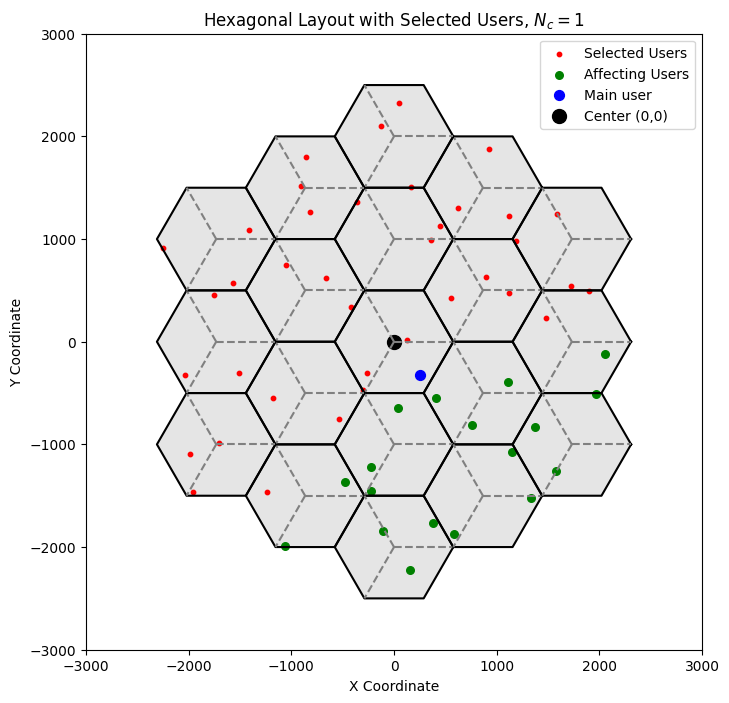

In [8]:
# Generate random points
nu = 3.8
alpha = 1
sigma = 8

users = generate_n_random_points_in_hexagons(hex_positions, radius, height)
distances_to_center = [10 * np.log10(np.sqrt((x - 0)**2 + (y - 0)**2)) for x, y, _, _ in users]
pathloss = [alpha - nu * d for d in distances_to_center] # in dB so subtracting instead of divide
pathloss_shadowing = [p + np.random.normal(0, sigma) for p in pathloss] # Combining pathloss and Shadowing : Lp * X
linear_ps  = [10 ** (p/10) for p in pathloss_shadowing]

curr = linear_ps[0][0]
curr_sector = calculate_sector(users[0][0][0], users[0][1][0], users[0][2], users[0][3])
interference = 0

affecting_users = []

for i in range(1, len(linear_ps)):
    directivity_side = calculate_sector(users[i][0][0], users[i][1][0], users[0][2], users[0][3]) == curr_sector
    if directivity_side:
        interference += linear_ps[i][0]
        affecting_users.append((users[i][0][0], users[i][1][0]))


SIR = curr / interference
print(f"SIR = {SIR}")


# Visualization
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
ax.set_title("Hexagonal Layout with Selected Users, $N_c = 1$")

# Plot each cell at the specified hexagonal coordinates
for (x, y) in hex_positions:
    plot_cell_with_sectors(ax, x, y, radius)



# Plot selected users
x_users, y_users, _, _ = zip(*users)
x_affusers, y_affusers = zip(*affecting_users)
ax.scatter(x_users, y_users, color='red', s=10, label="Selected Users")
ax.scatter(x_affusers, y_affusers, color='green', s=30, label="Affecting Users")
ax.scatter(users[0][0][0], users[0][1][0], color='blue', s=50, label="Main user")

# Highlight the central point
ax.scatter([0], [0], color='black', s=100, label='Center (0,0)')

plt.xlim(height * -3, height * 3)
plt.ylim(height * -3, height * 3)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.grid(False)
plt.show()